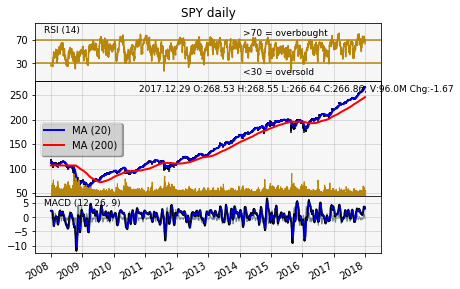

In [3]:
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

ticker = 'SPY'
r = pd.read_csv('market_data/yahoofinance-SPY-20080101-20180101.csv',
                index_col=0,
                parse_dates=True,
                infer_datetime_format=True)


def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a


def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi


def moving_average_convergence(x, nslow=26, nfast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 9
left, width = 0.1, 0.8
rect1 = [left, 0.7, width, 0.2]
rect2 = [left, 0.3, width, 0.4]
rect3 = [left, 0.1, width, 0.2]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color

ax1 = fig.add_axes(rect1, facecolor=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, facecolor=axescolor, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, facecolor=axescolor, sharex=ax1)


# plot the relative strength indicator
prices = r["Adj Close"]
rsi = relative_strength(prices)
fillcolor = 'darkgoldenrod'

ax1.plot(r.index, rsi, color=fillcolor)
ax1.axhline(70, color=fillcolor)
ax1.axhline(30, color=fillcolor)
ax1.fill_between(r.index, rsi, 70, where=(rsi >= 70),
                 facecolor=fillcolor, edgecolor=fillcolor)
ax1.fill_between(r.index, rsi, 30, where=(rsi <= 30),
                 facecolor=fillcolor, edgecolor=fillcolor)
ax1.text(0.6, 0.9, '>70 = overbought', va='top',
         transform=ax1.transAxes, fontsize=textsize)
ax1.text(0.6, 0.1, '<30 = oversold',
         transform=ax1.transAxes, fontsize=textsize)
ax1.set_ylim(0, 100)
ax1.set_yticks([30, 70])
ax1.text(0.025, 0.95, 'RSI (14)', va='top',
         transform=ax1.transAxes, fontsize=textsize)
ax1.set_title('%s daily' % ticker)

# plot the price and volume data
dx = r["Adj Close"] - r.Close
low = r.Low + dx
high = r.High + dx

deltas = np.zeros_like(prices)
deltas[1:] = np.diff(prices)
up = deltas > 0
ax2.vlines(r.index[up], low[up], high[up], color='black', label='_nolegend_')
ax2.vlines(r.index[~up], low[~up], high[~up],
           color='black', label='_nolegend_')
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')

linema20, = ax2.plot(r.index, ma20, color='blue', lw=2, label='MA (20)')
linema200, = ax2.plot(r.index, ma200, color='red', lw=2, label='MA (200)')

last = r.tail(1)
s = '%s O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f' % (
    last.index.strftime('%Y.%m.%d')[0],
    last.Open, last.High,
    last.Low, last.Close,
    last.Volume * 1e-6,
    last.Close - last.Open)
t4 = ax2.text(0.3, 0.9, s, transform=ax2.transAxes, fontsize=textsize)

props = font_manager.FontProperties(size=10)
leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
leg.get_frame().set_alpha(0.5)


volume = (r.Close * r.Volume) / 1e6  # dollar volume in millions
vmax = volume.max()
poly = ax2t.fill_between(r.index, volume, 0, label='Volume',
                         facecolor=fillcolor, edgecolor=fillcolor)
ax2t.set_ylim(0, 5 * vmax)
ax2t.set_yticks([])


# compute the MACD indicator
fillcolor = 'darkslategrey'
nslow = 26
nfast = 12
nema = 9
emaslow, emafast, macd = moving_average_convergence(
    prices, nslow=nslow, nfast=nfast)
ema9 = moving_average(macd, nema, type='exponential')
ax3.plot(r.index, macd, color='black', lw=2)
ax3.plot(r.index, ema9, color='blue', lw=1)
ax3.fill_between(r.index, macd - ema9, 0, alpha=0.5,
                 facecolor=fillcolor, edgecolor=fillcolor)


ax3.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (nfast, nslow, nema), va='top',
         transform=ax3.transAxes, fontsize=textsize)

# ax3.set_yticks([])
# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax1, ax2, ax2t, ax3:
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
# ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
# ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))


ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()